In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = "file_path"
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data--
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


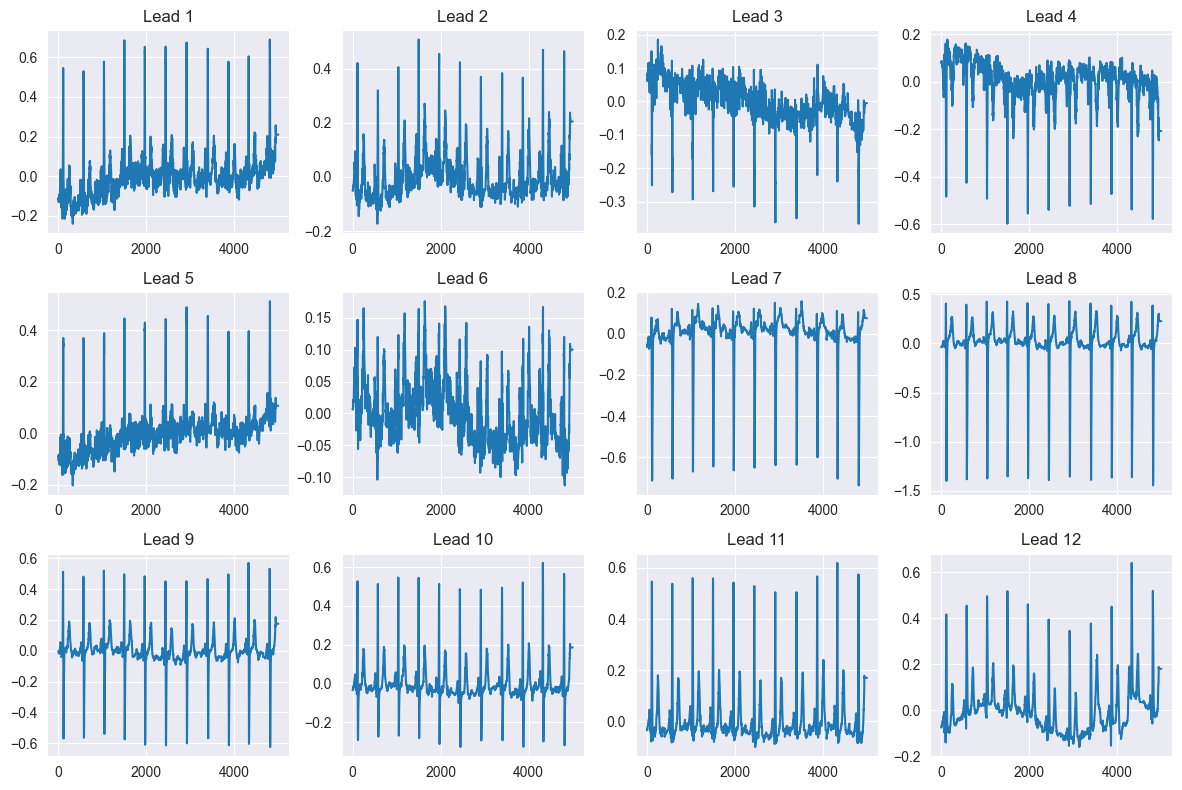

In [184]:
import numpy as np
import matplotlib.pyplot as plt
sample_index = 0
ecg_sample = X[sample_index]

# Plot each lead
plt.figure(figsize=(12, 8))
for lead_index in range(12):
    lead_data = ecg_sample[:, lead_index]  # Get data for a specific lead
    plt.subplot(3, 4, lead_index + 1)  # Create subplots for each lead
    plt.plot(lead_data)
    plt.title(f'Lead {lead_index + 1}')

plt.tight_layout()
plt.savefig('ecg_sample_plot.png')  # You can change the filename and extension as needed
plt.show()

In [141]:
#Lead I from sample 0
X[0,:,0]

array([-0.115, -0.115, -0.115, ...,  0.21 ,  0.21 ,  0.21 ])

In [9]:
import numpy as np

# Assuming your numpy array is named ecg_data
# ecg_data.shape = (22000, 500, 12)

# Extracting the specific indices
aVF = X[:20000, :, 5]
V3 = X[:, :, 8]
V10 = X[:, :, 10]
aVL= X[:, :, 4]
Lead_III= X[:, :, 2]
Lead_I= X[:, :, 0]
# Checking the shapes of extracted data
print("Shape of aVF:", aVF.shape)
print("Shape of V3:", V3.shape)
print("Shape of V10:", V10.shape)

Shape of aVF: (20000, 5000)
Shape of V3: (21837, 5000)
Shape of V10: (21837, 5000)


In [5]:
avf_df=pd.DataFrame(aVF)
avf_df.to_csv('avf.csv', index=False)


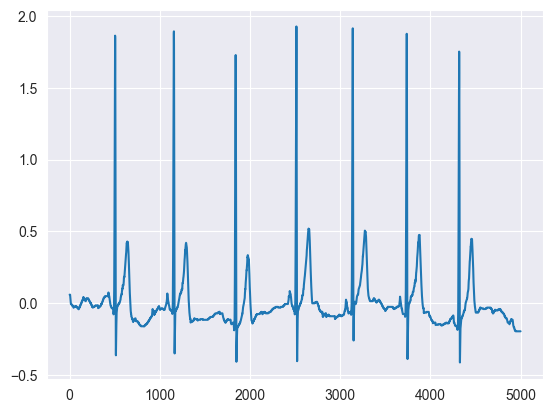

In [7]:
import matplotlib.pyplot as plt
plt.plot(V10[1])

In [144]:
# import numpy as np
#
# def combine_12_leads(weights, signal):
#     """
#     Combine 12-lead signals into a single combined signal based on specified weights for each lead.
#
#     :param weights: Dictionary containing weights for each lead.
#     :param signal: 3D array representing the 12-lead signal.
#     :return: Combined weighted signal.
#     """
#     # Calculate the total weight
#     total_weight = sum(weights.values())
#
#     # Initialize combined weighted signal with proper shape
#     combined_weighted_signal = np.zeros((signal.shape[0], signal.shape[1], 1))
#
#     # Calculate the weighted sum of signals across leads using mapping
#     for i in range(signal.shape[0]):
#         for lead, weight in weights.items():
#             # Perform element-wise multiplication and addition to calculate combined signal
#             combined_weighted_signal[i] += (signal[i, :, lead] * weight).reshape(-1, 1)
#
#     # Normalize by dividing by total weight
#     combined_weighted_signal /= total_weight
#
#     print("New shape:", combined_weighted_signal.shape)
#     return combined_weighted_signal
# combined_weighted_signal=combine_12_leads(weights = {0: 1, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1},signal=X)

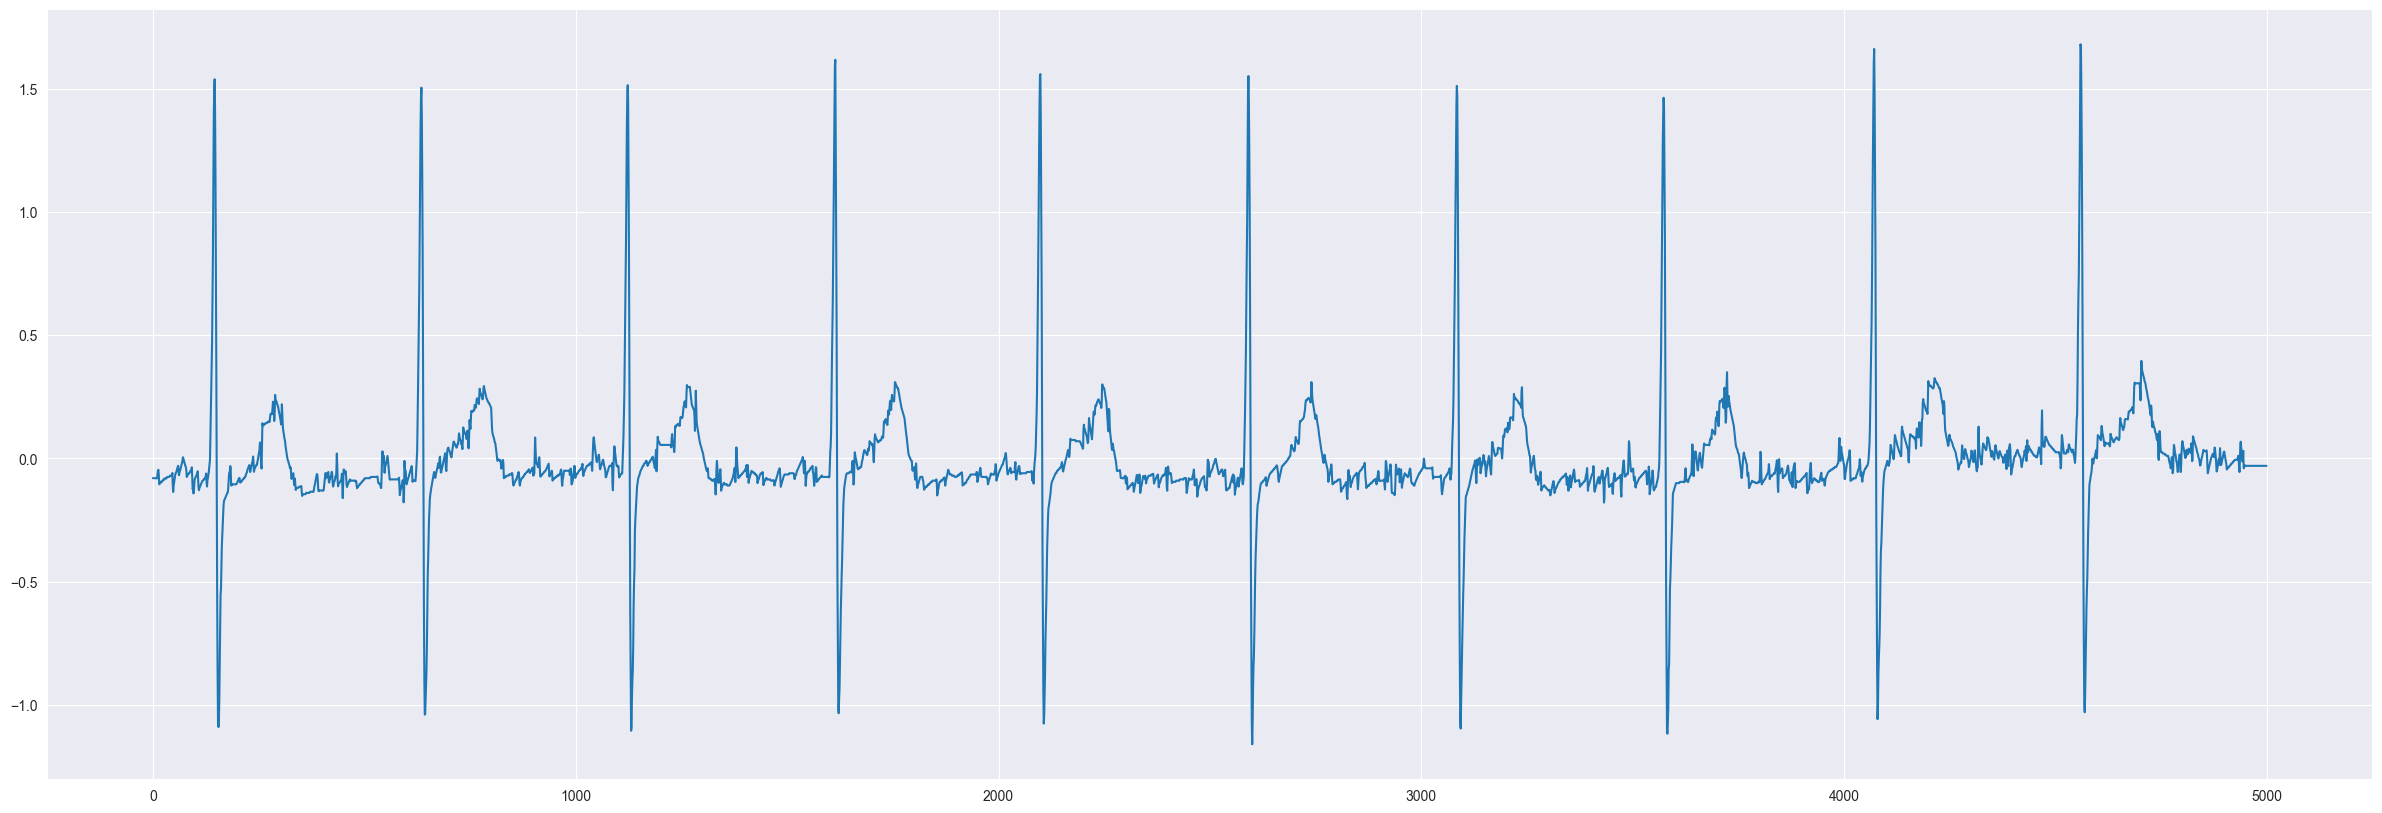

In [145]:
plt.figure(figsize=(30,10))
plt.plot(V3[3354])


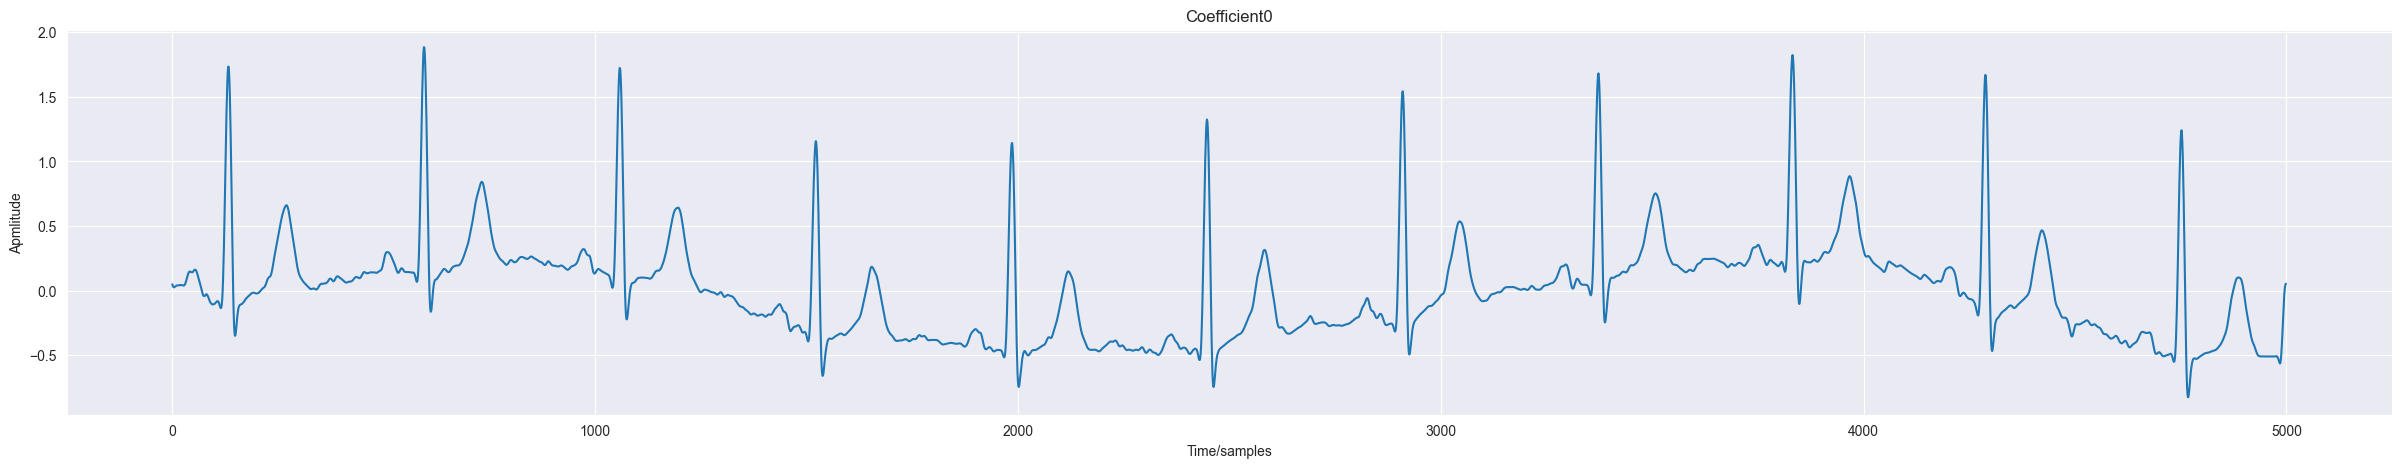

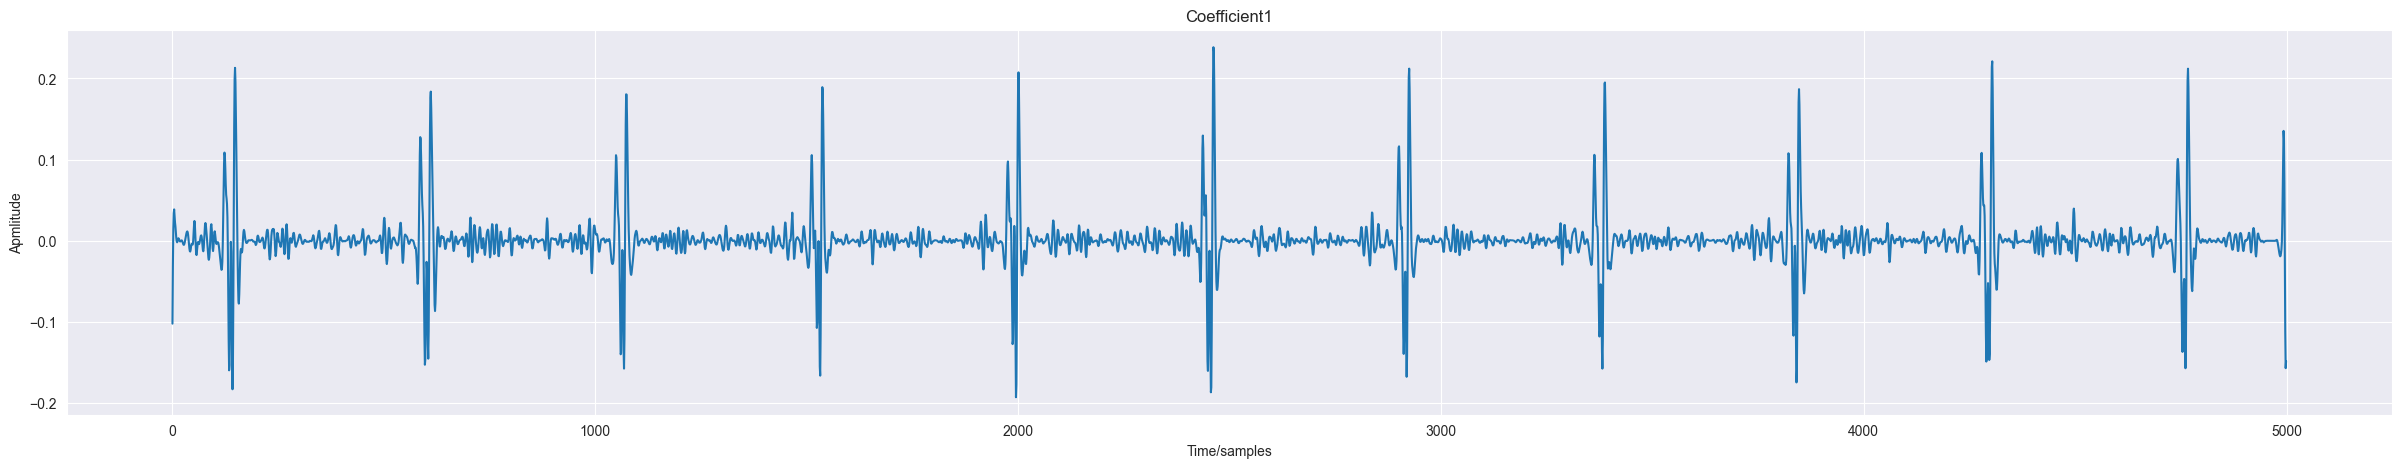

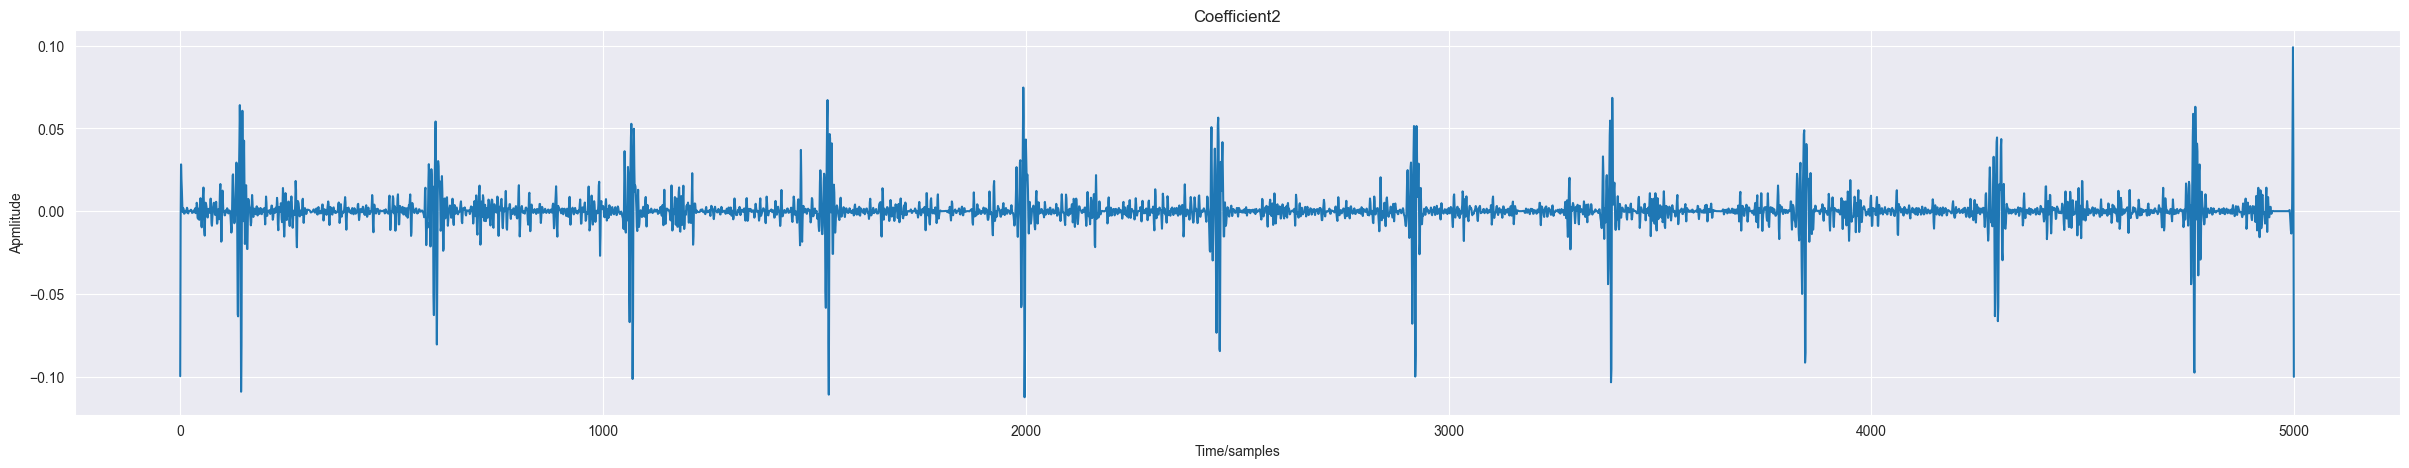

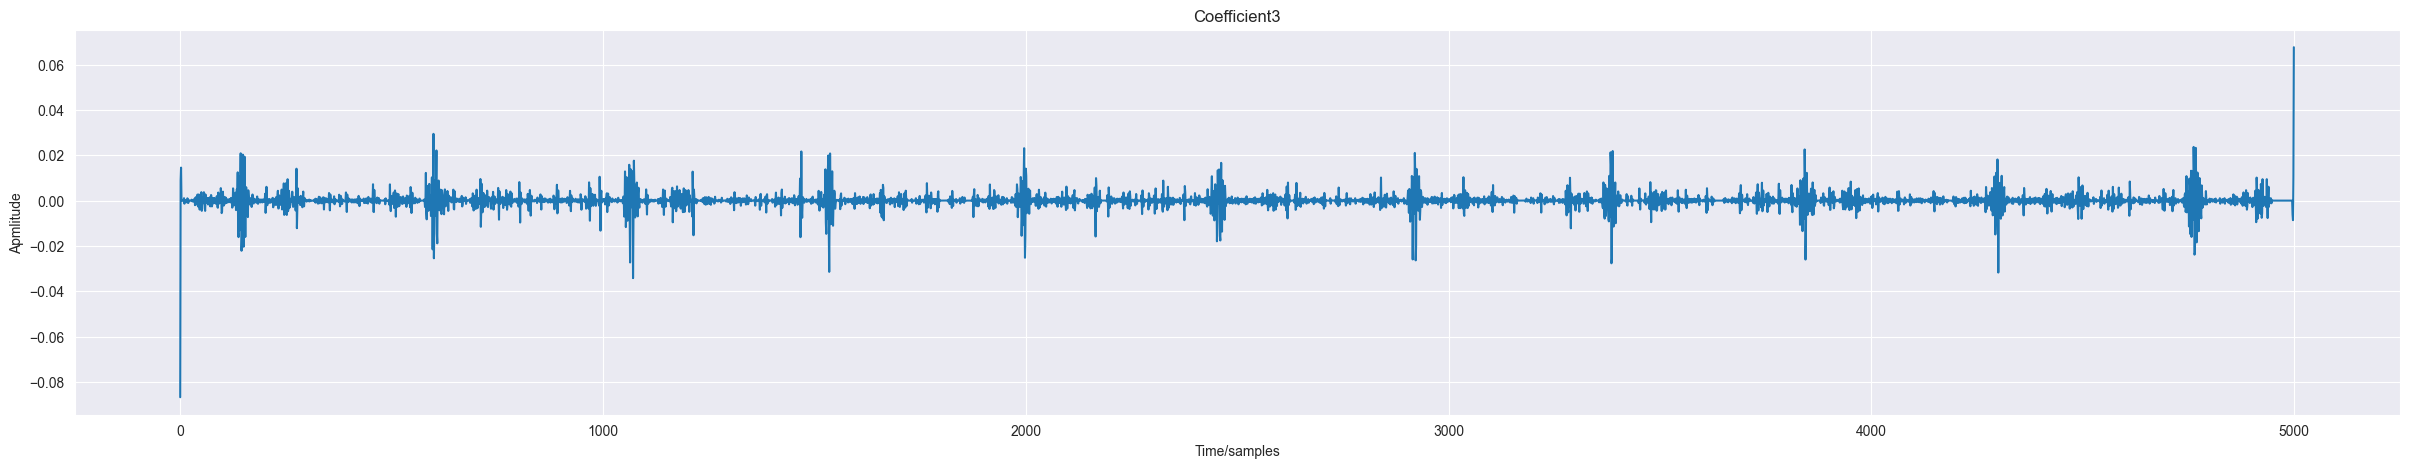

In [15]:

def plot_wavelet_analysis(ECG,wavelet,level=3):
    """
    Takes the ECG signal and decomposes it into its CD and CA compositions
    in the case level=3, we have CA3,CD3,CD2,CD1. change them if you chose a different level of decomposition
    :param ECG: 1D array
    :param wavelet: for ECG sym4 is usually chosen.
    :param level: usually 3 or 4 is chosen.
    :return: plots CD and CA compositions.
    """
    import pywt
    coefs=pywt.swt(ECG,wavelet=wavelet,level=level, axis=0,trim_approx=True)
    CA3,CD3,CD2,CD1=coefs
    coef_list=[CA3,CD3,CD2,CD1]
    n=0
    for coef in coef_list:
        plt.figure(figsize=(30,5))
        plt.plot(coef)
        plt.xlabel('Time/samples')
        plt.ylabel('Apmlitude')
        plt.title(f'Coefficient{n}')
        plt.show()
        n+=1

plot_wavelet_analysis(aVF[1000],'sym4',3)

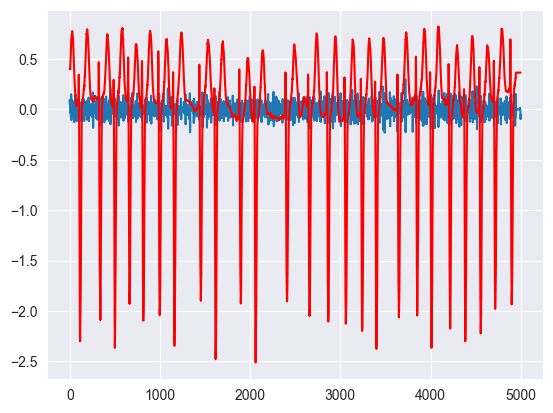

In [8]:
def wavelet_analysis(ECG,wavelet,level=3):
    """
    Based on the ECG signal, wavelet form and level of decompostion, reconstrucs the signal
    :param ECG: 1D array
    :param wavelet: Usually sym4 is chosen.
    :param level: change this according to your needs
    :return: reconstructed signal
    """
    import pywt
    coefs=pywt.swt(ECG,wavelet=wavelet,level=level, axis=0,trim_approx=True)

    # I chose not to consider the coefficients below. you can change this according to your needs
    coefs[-1]=np.zeros_like(coefs[-1])
    coefs[0]=np.zeros_like(coefs[0])

    signal_rec=pywt.iswt(coefs,wavelet=wavelet, axis=0)

    return signal_rec
signals=wavelet_analysis(aVF[3354],'sym4',3)
plt.plot(signals)
plt.plot(V3[2000],'r')

In [10]:
avf_list = []

# Iterate over each sample in aVF and apply wavelet analysis
for i in range(len(aVF)):
    avf_list.append(wavelet_analysis(aVF[i], 'sym4'))

# Convert the list of wavelet transformed data into a DataFrame
avf_df = pd.DataFrame(avf_list)

# Save the DataFrame as a CSV file
avf_df.to_csv('avf_wavelet_transformed.csv', index=False)

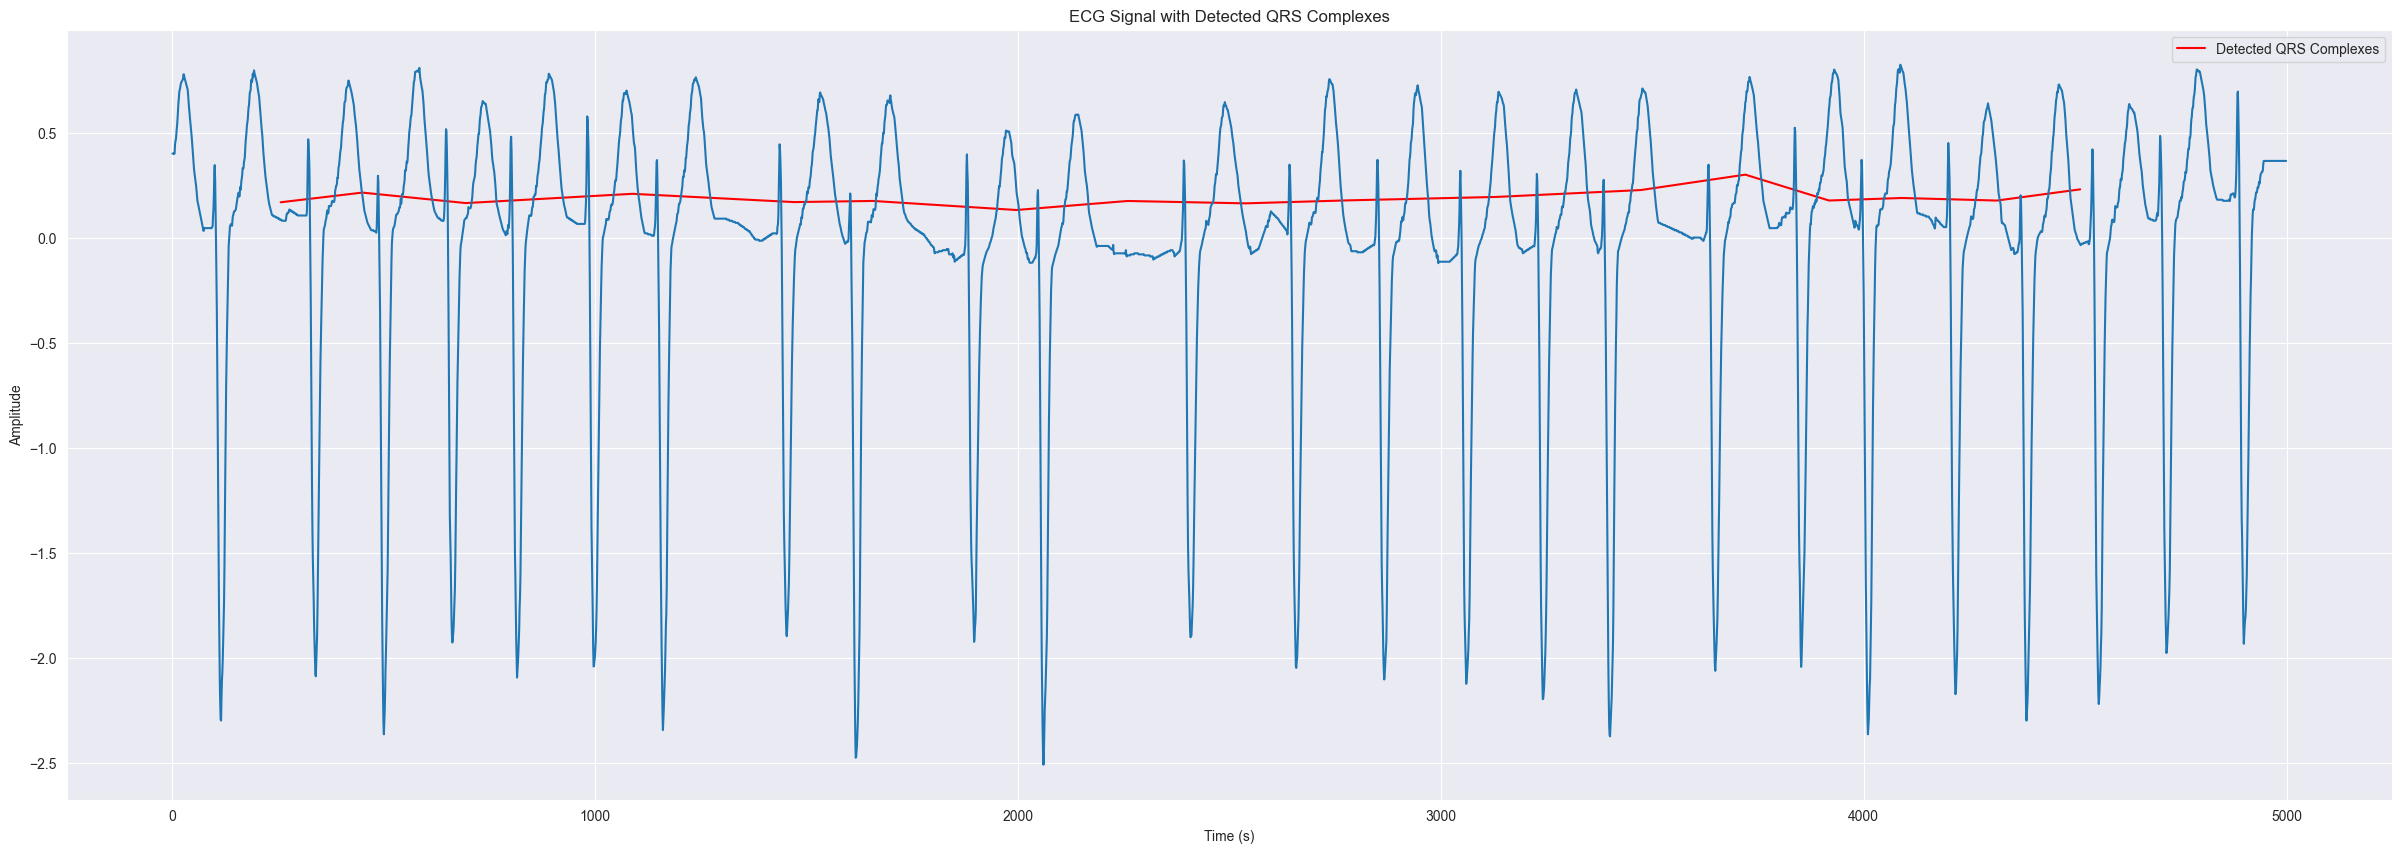

<Figure size 640x480 with 0 Axes>

In [148]:
def R_finder(signals):
    """
    Based on the reconstructed signa, finds the R peaks of the ECG signal
    :param signals: reconstructed signal/ The original sigan could also be used.
    :return: R peak indexes and amplitudes
    """
    from scipy.signal import argrelmax
    from scipy.signal import find_peaks

    signals_1d = np.squeeze(signals)
    y_prime=np.abs(signals_1d)**2
    average=y_prime.mean()
    R_peaks, properties = find_peaks(signals_1d, height=9*average,distance=75)
    peak_indices = argrelmax(properties['peak_heights'])
    R_peaks=R_peaks[peak_indices]
    peak_values=properties['peak_heights'][peak_indices]

    return R_peaks,peak_values

# plt.plot(R_peaks,properties, 'r', label='Detected QRS Complexes')
# plt.scatter(R_peaks[peak_indices],peak_values)

peak_indices,peak_values=R_finder(signals)
plt.figure(figsize=(30,10))
plt.plot(peak_indices,peak_values, 'r', label='Detected QRS Complexes')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Detected QRS Complexes')
plt.legend()
plt.grid(True)
plt.plot(V3[2000])
plt.show()
plt.tight_layout()

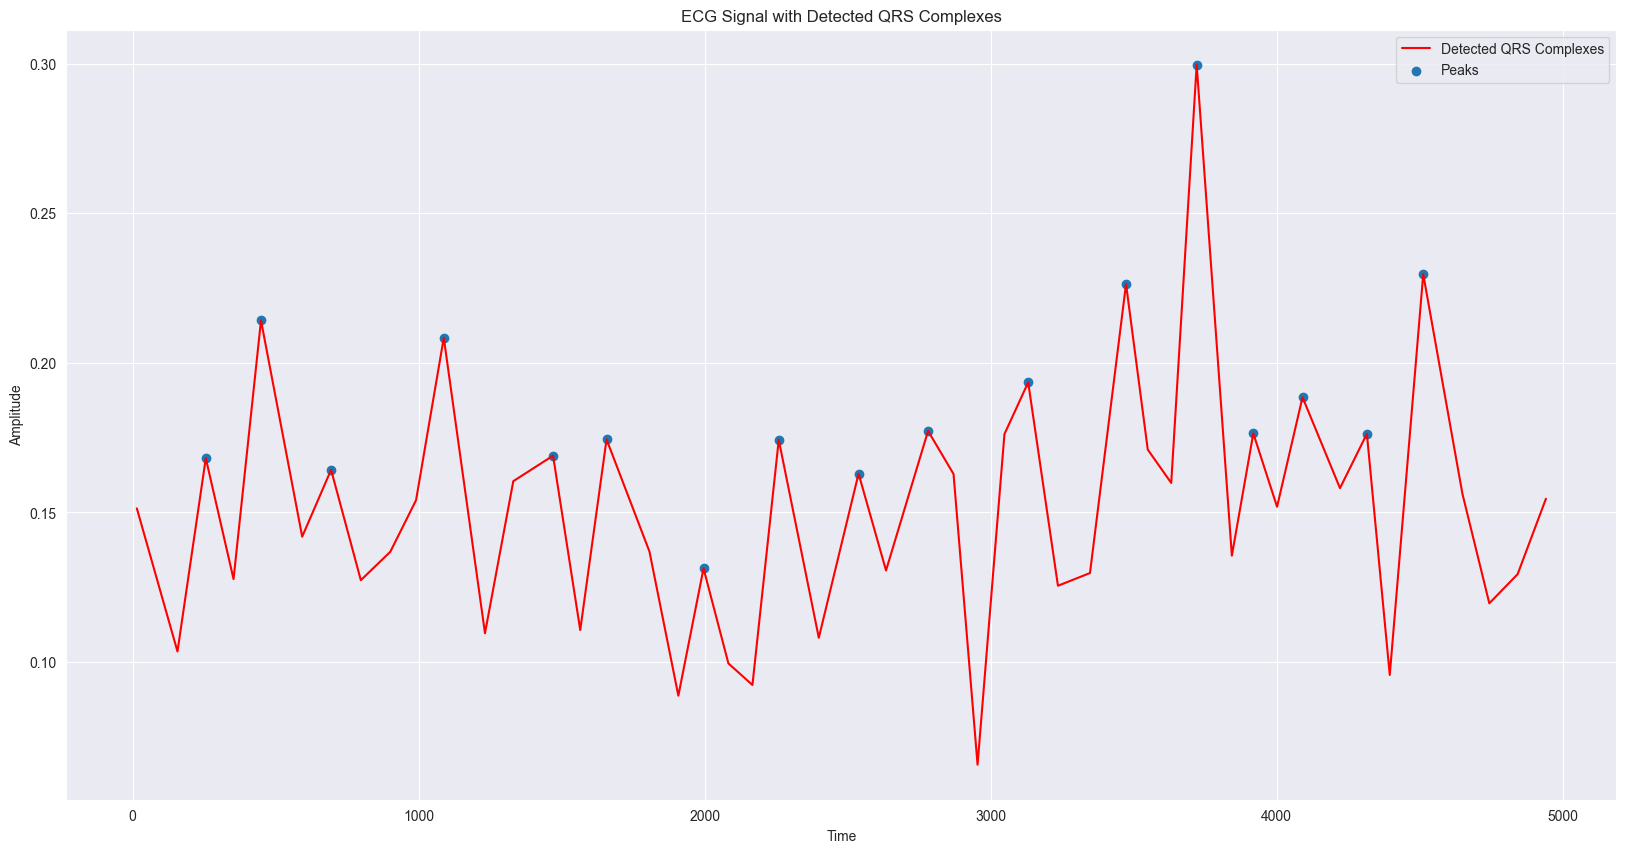

In [149]:
def R_plot(signals):
    """

    :param signals: 1D array of a signal
    :return: plots the signal and its identified R peaks
    """
    from scipy.signal import argrelmax
    from scipy.signal import find_peaks
    signals_1d = np.squeeze(signals)
    y_prime=np.abs(signals_1d)**2
    average=y_prime.mean()

    # Height and distance values can be changed based on your needs
    R_peaks, properties = find_peaks(signals_1d, height=9*average,distance=75)
    peak_indices = argrelmax(properties['peak_heights'])
    peak_values=properties['peak_heights'][peak_indices]
    plt.figure(figsize=(20,10))
    plt.plot(R_peaks,properties['peak_heights'], 'r', label='Detected QRS Complexes')
    plt.scatter(R_peaks[peak_indices],peak_values,label='Peaks')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('ECG Signal with Detected QRS Complexes')
    plt.legend()

R_plot(signals)




[ 9.45141437e-03 -1.38079015e-03  1.17722901e-03 -8.23734358e-04
 -9.17021507e-05  6.79150841e-03  7.99981795e-03  6.70706414e-03
  4.47526340e-04  5.61198512e-04]


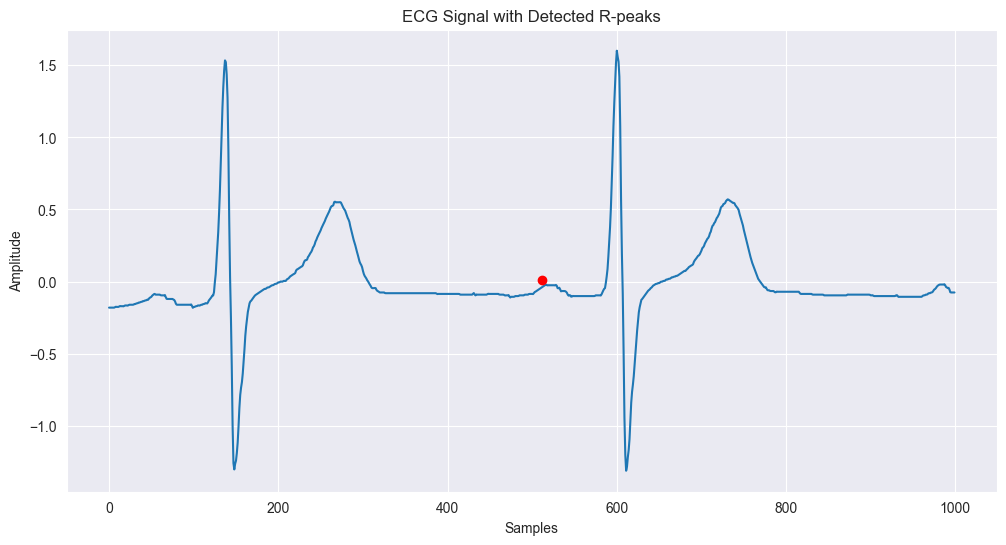

In [27]:
def PQRS_extraction(V3,aVF,sampling_rate=500):
    """
    works better on V3 Lead for QRS extraction.
    P wave should be extracted from aVF
    :param ECG: Signal array
    :param sampling_rate: based your own data
    :return: PQRS indexes and amplitudes based on the ECG provided
    """
    import neurokit2 as nk
    try:
        # Assuming combined_weighted_signal[2000] contains your ECG signal data
        ecg=wavelet_analysis(V3,'sym4')
        avf_ecg=wavelet_analysis(aVF,'sym4')
        # Ensure the ECG signal data is in the correct format (1-dimensional array)
        ecg_signal = np.squeeze(ecg)
        evf_signal= np.squeeze(avf_ecg)

        ecg_info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)
        evf_info= nk.ecg_process(evf_signal, sampling_rate=sampling_rate)
        # Get the R-peaks indices
        r_peaks = ecg_info[1]["ECG_R_Peaks"]

        r_amplitude=ecg[r_peaks]

        p_peaks = evf_info[1]["ECG_P_Peaks"]
        q_peaks = ecg_info[1]["ECG_Q_Peaks"]
        s_peaks = ecg_info[1]["ECG_S_Peaks"]

        valid_p_peaks = [peak for peak in p_peaks if not np.isnan(peak)]
        valid_q_peaks = [peak for peak in q_peaks if not np.isnan(peak)]
        valid_s_peaks = [peak for peak in s_peaks if not np.isnan(peak)]

        # You can also get the amplitudes of the peaks
        p_amplitudes = avf_ecg[valid_p_peaks]
        q_amplitudes = ecg[valid_q_peaks]
        s_amplitudes = ecg[valid_s_peaks]

        return r_peaks, r_amplitude,valid_p_peaks,p_amplitudes,valid_q_peaks,q_amplitudes,valid_s_peaks,s_amplitudes
    except Exception as e:
        print("Error:", e)
        # Return NaN or 0 for all durations if an error occurs
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan


s=wavelet_analysis(V3[1000],'sym4')
r_peaks, r_amplitude,valid_p_peaks,p_amplitudes,valid_q_peaks,q_amplitudes,valid_s_peaks,s_amplitudes = PQRS_extraction(V3[1000],aVF[1000])
print(p_amplitudes)
plt.figure(figsize=(12, 6))
plt.plot(V3[1000][:1000])
plt.plot(valid_p_peaks[:1], p_amplitudes[:1], "ro")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-peaks")
plt.grid(True)
plt.show()

In [160]:
def HR_counter(ECG,sample_rate=500):
    """
    Counts the heart rate based on the data provided. works better on V3 Lead
    :param ECG: 1D signal array
    :param sample_rate: based on your own data
    :return: rounded Heart Rate
    """
    import neurokit2 as nk
    try:
        # Assuming that youre using sym4 wavelet
        ecg=wavelet_analysis(ECG,'sym4')

        # Ensure the ECG signal data is in the correct format (1-dimensional array)
        ecg_signal = np.squeeze(ecg)

        ecg_info = nk.ecg_process(ecg_signal, sampling_rate=sample_rate)

        # Get the R-peaks indices
        r_peaks = ecg_info[1]["ECG_R_Peaks"]
        RR_intervals = np.mean(np.diff(r_peaks)/sample_rate)
        heart_rate = 60 / RR_intervals  # Convert to beats per minute (BPM)
        return round(heart_rate,0)
    except Exception as e:
            print("Error:", e)
            # Return NaN or 0 for all durations if an error occurs
            return np.nan

HR_counter(V3[3354])


61.0

In [152]:
def mean_PQRS_amplitude(V3,aVF,sampling_rate=500):
    """
    based on the signal, extracts and calculates the mean of PQRS amplitudes,works better on V3 Lead
    :param ECG: 1D signal array
    :param sampling_rate: based on your own data
    :return: mean values of PQRS peaks
    """
    # s=wavelet_analysis(ECG,'sym4')
    try:
        r_peaks, r_amplitude,valid_p_peaks,p_amplitudes,valid_q_peaks,q_amplitudes,valid_s_peaks,s_amplitudes =PQRS_extraction(V3,aVF,sampling_rate=sampling_rate)
        mean_r_peaks=r_amplitude.mean()
        mean_p_peaks=p_amplitudes.mean()
        mean_q_peaks=q_amplitudes.mean()
        mean_s_peaks=s_amplitudes.mean()

        return mean_r_peaks,mean_p_peaks,mean_q_peaks,mean_s_peaks
    except Exception as e:
        print("Error:", e)
        # Return NaN or 0 for all durations if an error occurs
        return np.nan, np.nan, np.nan, np.nan

mean_PQRS_amplitude(V3[3354],aVF[3354])


Error: cannot convert float NaN to integer
Error: 'float' object has no attribute 'mean'


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


(nan, nan, nan, nan)

In [153]:
def wave_duration(avf,sampling_rate=500):
    """
    calculates the PR segment and Rwave and Pwave durations,aVF lead seems to work best
    :param ECG: 1D signal array
    :param sampling_rate: based on your own data
    :return: Rwave and Pwave duration and PR segment
    """
    import neurokit2 as nk
        # ecg_cleaned = np.nan_to_num(avf, nan=0)
    try:
        # Assuming combined_weighted_signal[2000] contains your ECG signal data
        ecg=wavelet_analysis(avf,'sym4')

        # Ensure the ECG signal data is in the correct format (1-dimensional array)
        ecg_signal = np.squeeze(ecg)

        ecg_info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)
        # Get the wave onset and offsets
        r_onset = ecg_info[1]["ECG_Q_Peaks"]
        r_offset=ecg_info[1]["ECG_S_Peaks"]
        p_onset = ecg_info[1]["ECG_P_Onsets"]
        p_offset=ecg_info[1]["ECG_P_Offsets"]
        t_offset=ecg_info[1]["ECG_T_Offsets"]
        t_onset=ecg_info[1]["ECG_T_Onsets"]

        VALID_r_onset=np.array(r_onset)
        VALID_r_offset=np.array(r_offset)

        # valid_r_onsets = [onset for onset in r_onset if not np.isnan(onset)]
        # valid_r_offsets = [offset for offset in r_offset if not np.isnan(offset)]

        VALID_p_onset=np.array(p_onset)
        VALID_p_offset=np.array(p_offset)

        VALID_t_offset=np.array(t_offset)
        VALID_t_onset=np.array(t_onset)



        pwaves=VALID_p_offset-VALID_p_onset
        P_waves=[wave for wave in pwaves if not np.isnan(wave)]

        twave=VALID_t_offset-VALID_t_onset
        T_wave=[wave for wave in twave if not np.isnan(wave)]

        rwaves=VALID_r_offset-VALID_r_onset
        R_waves=[wave for wave in rwaves if not np.isnan(wave)]


        mean_rwave_duration=np.mean(R_waves)/sampling_rate # in seconds
        mean_pwave_duration=np.mean(P_waves)/sampling_rate # in seconds
        mean_twave_duration=np.mean(T_wave)/sampling_rate # in seconds

        # Convert lists to numpy arrays to handle nan values
        ECG_P_onset_arr = np.array(p_onset)
        ECG_Q_Peaks_arr = np.array(r_onset)
        Difference = ECG_Q_Peaks_arr - ECG_P_onset_arr

        ECG_S_offset=np.array(r_offset)
        ECG_T_onset =np.array(t_onset)
        Diff=ECG_T_onset-ECG_S_offset

        valid_PR_segment=[segment for segment in Difference if not np.isnan(segment)]
        mean_PR_segment=np.mean(valid_PR_segment)/sampling_rate

        valid_ST_segment=[segment for segment in Diff if not np.isnan(segment)]
        mean_ST_segment=np.mean(valid_ST_segment)/sampling_rate

        return round(mean_rwave_duration,2), round(mean_pwave_duration,2),round(mean_twave_duration,2),round(mean_PR_segment,3),round(mean_ST_segment,3)
    except Exception as e:
        print("Error:", e)
        # Return NaN or 0 for all durations if an error occurs
        return np.nan, np.nan, np.nan, np.nan, np.nan

wave_duration(aVF[3354])


Error: cannot convert float NaN to integer


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


(nan, nan, nan, nan, nan)

In [158]:
def RR_ratio(ECG,sampling_rate=500):
    """
    calculates the RR ratio which is: RR(i)/RR(i+1). use V3 lead
    :param ECG:
    :param sampling_rate:
    :return: rounded RR_ratio to 2 decimals
    """
    import neurokit2 as nk
    try:
        # Assuming combined_weighted_signal[2000] contains your ECG signal data
        ecg=wavelet_analysis(ECG,'sym4')

        # Ensure the ECG signal data is in the correct format (1-dimensional array)
        ecg_signal = np.squeeze(ecg)

        ecg_info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)

        # Get the R-peaks indices
        r_peaks = ecg_info[1]["ECG_R_Peaks"]
        RR_intervals = np.diff(r_peaks)/sampling_rate
        rr_ratios = []
        for i in range(len(RR_intervals) - 1):
            rr_ratio = RR_intervals[i] / RR_intervals[i + 1]
            rr_ratios.append(rr_ratio)

        RR_R = np.mean(rr_ratios)

        return round(RR_R,2)
    except Exception as e:
        print("Error:", e)
        # Return NaN or 0 for all durations if an error occurs
        return np.nan

RR_ratio(V3[3354])


1.0

In [159]:
import numpy as np

def calculate_axis_deviation(ecg_lead_III, ecg_lead_aVL, ecg_lead_aVF):
    """
    Calculate the electrical axis deviation from an ECG.

    Args:
    ecg_lead_III (numpy array): ECG signal from lead III
    ecg_lead_aVL (numpy array): ECG signal from lead aVL
    ecg_lead_aVF (numpy array): ECG signal from lead aVF

    Returns:
    axis_deviation (str): Description of the axis deviation (e.g., "Normal", "Left Axis Deviation", "Right Axis Deviation")
    """
    try:
        # Calculate mean QRS amplitudes in leads I, II, and III
        mean_amplitude_III = np.mean(ecg_lead_III)
        mean_amplitude_aVL = np.mean(ecg_lead_aVL)
        mean_amplitude_aVF = np.mean(ecg_lead_aVF)

        # Determine the axis deviation based on net deflection in leads III and aVF
        if mean_amplitude_III > 0 and mean_amplitude_aVF > 0:
            axis_deviation = "Normal or Left Axis Deviation"
        elif mean_amplitude_III < 0 and mean_amplitude_aVF < 0:
            axis_deviation = "Right Axis Deviation"
        else:
            # Look at lead I to differentiate between left and right axis deviation
            if mean_amplitude_aVL > 0:
                axis_deviation = "Left Axis Deviation"
            else:
                axis_deviation = "Right Axis Deviation"

        return axis_deviation
    except Exception as e:
        print("Error:", e)
        # Return NaN or 0 for all durations if an error occurs
        return np.nan
# Calculate axis deviation
axis_deviation = calculate_axis_deviation(Lead_III[1000],aVL[1000],aVF[1000])

# Print the result
print("Axis Deviation:", axis_deviation)


Axis Deviation: Left Axis Deviation


In [162]:
def extraction(Lead_III,aVL,aVF,V3):
    """

    :param combined_weighted_signal: The 1D array of original ECG signal
    :return: A data fram of extracted features
    """
    HR_list = []
    RR_list = []
    R_wave_duration_list = []
    P_wave_duration_list = []
    PR_interval_list = []
    R_peak_list = []
    P_peak_list = []
    Q_peak_list = []
    S_peak_list = []
    T_wave_duration_list = []
    ST_interval_list = []
    axis_list = []

    for item in range(20000):
        print(item)

        Lead3=Lead_III[item]
        avl=aVL[item]
        avf=aVF[item]
        v3=V3[item]

        HR=HR_counter(v3)
        RR=RR_ratio(v3)
        R_wave_duration,P_wave_duration,T_wave_duration,PR_interval,ST_interval=wave_duration(avf)
        R_peak,P_peak,Q_peak,S_peak=mean_PQRS_amplitude(v3,avf)
        axis=calculate_axis_deviation(Lead3,avl,avf)

        # Append extracted features to lists
        HR_list.append(HR)
        RR_list.append(RR)
        R_wave_duration_list.append(R_wave_duration)
        P_wave_duration_list.append(P_wave_duration)
        PR_interval_list.append(PR_interval)
        R_peak_list.append(R_peak)
        P_peak_list.append(P_peak)
        Q_peak_list.append(Q_peak)
        S_peak_list.append(S_peak)
        T_wave_duration_list.append(T_wave_duration)
        ST_interval_list.append(ST_interval)
        axis_list.append(axis)
    # Create a DataFrame from the lists
    data = {
        'HR': HR_list,
        'RR': RR_list,
        'R_wave_duration': R_wave_duration_list,
        'P_wave_duration': P_wave_duration_list,
        'T_wave_duration': T_wave_duration_list,
        'PR_interval': PR_interval_list,
        'ST_interval': ST_interval_list,
        'R_peak': R_peak_list,
        'P_peak': P_peak_list,
        'Q_peak': Q_peak_list,
        'S_peak': S_peak_list,
        'Axis': axis_list


    }
    df = pd.DataFrame(data)
    return df
df=extraction(Lead_III,aVL,aVF,V3)
df.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer
Error: cannot convert float NaN to integer
Error: 'float' object has no attribute 'mean'
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= 

5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer
Error: cannot convert float NaN to integer
Error: 'float' object has no attribute 'mean'
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937
7938
7939
7940
7941
7942
7943
7944
7945
7946
7947
7948
7949
7950
7951
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961
7962
7963
7964
7965
7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
7986
7987
7988
7989
7990
7991
7992
7993
7994
7995
7996
7997
7998
7999
8000
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
8984
8985
8986
8987
8988
8989
8990
8991
8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /=

9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
1045

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
11379
11380
11381
11382
11383
11384
11385
11386
11387
11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399
11400
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\sign

Error: cannot convert float NaN to integer
Error: cannot convert float NaN to integer
Error: 'float' object has no attribute 'mean'
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
1156

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
1173

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184
12185
12186
12187
12188
12189
12190
12191
12192
12193
12194
12195
12196
12197
12198
12199
12200
12201
12202
12203
12204
12205
12206
12207
12208
12209
12210
12211
12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
12251
12252
12253
12254
12255
12256
12257
12258
12259
12260
12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273
12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
12284
12285
12286
12287
12288
12289
12290
12291
12292
12293
12294
12295
12296
12297
12298
12299
12300
12301
12302
12303
12304
12305
12306
12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319
12320
1232

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
12470
12471
12472
12473
12474
12475
12476
12477
12478
12479
12480
12481
12482
12483
12484
12485
12486
12487
12488
12489
12490
12491
12492
12493
12494
12495
12496
12497
12498
12499
12500
12501
12502
12503
12504
12505
12506
12507
12508
12509
12510
12511
12512
12513
12514
12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
1258

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12730
12731
12732
12733
12734
12735
12736
12737
12738
12739
12740
12741
12742
12743
12744
12745
12746
12747
12748
12749
12750
12751
12752
12753
12754
12755
12756
12757
12758
12759
12760
12761
12762
12763
12764
12765
12766
12767
12768
12769
12770
12771
12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
1289

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402
13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419
13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441
13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452
13453
13454
13455
13456
13457
13458
13459
13460
13461
13462
13463
13464
13465
13466
13467
13468
13469
13470
13471
13472
13473
13474
13475
13476
13477
13478
13479
13480
13481
13482
1348

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /=

13956
13957
13958
13959
13960
13961
13962
13963
13964
13965
13966
13967
13968
13969
13970
13971
13972
13973
13974
13975
13976
13977
13978
13979
13980
13981
13982
13983
13984
13985
13986
13987
13988
13989
13990
13991
13992
13993
13994
13995
13996
13997
13998
13999
14000
14001
14002
14003
14004
14005
14006
14007
14008
14009
14010
14011
14012
14013
14014
14015
14016
14017
14018
14019
14020
14021
14022
14023
14024
14025
14026
14027
14028
14029
14030
14031
14032
14033
14034
14035
14036
14037
14038
14039
14040
14041
14042
14043
14044
14045
14046
14047
14048
14049
14050
14051
14052
14053
14054
14055
14056
14057
14058
14059
14060
14061
14062
14063
14064
14065
14066
14067
14068
14069
14070
14071
14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
1412

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer
Error: cannot convert float NaN to integer
Error: 'float' object has no attribute 'mean'
14197
14198
14199


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer
Error: cannot convert float NaN to integer
Error: 'float' object has no attribute 'mean'
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
1462

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14814
14815
14816
14817
14818
14819
14820
14821
14822
14823
14824
14825
14826
14827
14828
14829
14830
14831
14832
14833
14834
14835
14836
14837
14838
14839
14840
14841
14842
14843
14844
14845
14846
14847
14848
14849
14850
14851
14852
14853


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


14854
14855
14856
14857
14858
14859
14860
14861
14862


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14863
14864
14865
14866
14867
14868
14869
14870
14871
14872
14873
14874
14875
14876
14877
14878
14879
14880
14881
14882
14883
14884
14885
14886
14887
14888
14889
14890
14891
14892
14893
14894
14895
14896
14897
14898
14899
14900
14901
14902
14903
14904
14905
14906
14907
14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970
14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
15159
15160
15161
15162
15163
15164
15165
15166
15167
15168
15169
15170
15171
15172
15173
15174
15175
15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186
15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199
15200
15201
15202
15203
15204
15205
15206
15207
15208
15209
15210
15211
15212
15213
15214
15215
15216
15217
15218
15219
15220
15221
15222
15223
15224
15225
15226
15227
15228
15229
15230
15231
15232
15233
15234
15235
15236
15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
15249
15250
15251


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15252
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
15280
15281
15282
15283
15284
15285
15286
15287
15288
15289
15290
15291
15292
15293
15294
15295
15296
15297
15298
15299
15300
15301
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
1541

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /=

15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
1583

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error: cannot convert float NaN to integer
Error: cannot convert float NaN to integer
Error: 'float' object has no attribute 'mean'
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
1617

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /=

16431
16432
16433
16434
16435
16436
16437
16438
16439
16440
16441
16442
16443
16444
16445
16446
16447
16448
16449
16450
16451
16452
16453
16454
16455
16456
16457
16458
16459
16460
16461
16462
16463
16464
16465
16466
16467
16468
16469
16470
16471
16472
16473
16474
16475
16476
16477
16478
16479
16480
16481
16482
16483
16484
16485
16486
16487
16488
16489
16490
16491
16492
16493
16494
16495
16496
16497
16498
16499
16500
16501
16502
16503
16504
16505
16506
16507
16508
16509
16510
16511
16512
16513
16514
16515
16516
16517
16518
16519
16520
16521
16522
16523
16524
16525
16526
16527
16528
16529
16530
16531
16532
16533
16534
16535
16536
16537
16538
16539
16540
16541
16542
16543
16544
16545
16546
16547
16548
16549
16550
16551
16552
16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563
16564
16565
16566
16567
16568
16569
16570
16571
16572
16573
16574
16575
16576
16577
16578
16579
16580
16581
16582
16583
16584
16585
16586
16587
16588
16589
16590
16591
16592
16593
16594
16595
16596
1659

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


16874
16875
16876
16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
1704

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
1739

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17855
17856
17857
17858
17859
17860
17861
17862
17863
17864
17865
17866
17867
17868
17869
17870
17871
17872
17873
17874
17875
17876
17877
17878
17879
17880
17881
17882
17883
17884
17885
17886
17887
17888
17889
17890
17891
17892
17893
17894
17895
17896
17897
17898
17899
17900
17901
17902
17903
17904
17905
17906
17907
17908
17909
17910
17911
17912
17913
17914
17915
17916
17917
17918
17919
17920
17921
17922
17923
17924
17925
17926
1792

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17979
17980
17981
17982
17983
17984
17985
17986
17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
17999
18000
18001
18002
18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014
18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
1814

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18253
18254
18255
18256
18257
18258
18259
18260
18261
18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
1841

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /=

18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
18872
18873
18874
18875
18876
18877
18878
18879
18880
18881
18882
18883
18884
18885
18886
18887
18888
18889
18890
18891
18892
18893
18894
18895
18896
18897
18898
18899
18900
18901
18902
18903
18904
18905
18906
18907
18908
18909
18910
18911
18912
18913
18914
18915
18916
18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
1899

C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19249
19250
19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275
19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
19286
19287
19288
19289
19290
19291
19292
19293
19294
19295
19296
19297
19298
19299
19300
19301
19302
19303
19304
19305
19306
19307
19308
19309
19310
19311
19312
19313
19314
19315
19316
19317
19318
19319
19320
19321
19322
19323
19324
19325
19326
19327
19328
19329
19330
19331
19332
19333
19334
19335
19336
19337
19338
19339
19340
19341
19342
19343
19344
19345
19346
19347
19348
19349
19350
19351
19352
19353
19354
19355
19356
19357
19358
19359
19360
19361
19362
19363
19364


C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\.conda\envs\pythonProject\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19365
19366
19367
19368
19369
19370
19371
19372
19373
19374
19375
19376
19377
19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
19388
19389
19390
19391
19392
19393
19394
19395
19396
19397
19398
19399
19400
19401
19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412
19413
19414
19415
19416
19417
19418
19419
19420
19421
19422
19423
19424
19425
19426
19427
19428
19429
19430
19431
19432
19433
19434
19435
19436
19437
19438
19439
19440
19441
19442
19443
19444
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454
19455
19456
19457
19458
19459
19460
19461
19462
19463
19464
19465
19466
19467
19468
19469
19470
19471
19472
19473
19474
19475
19476
19477
19478
19479
19480
19481
19482
19483
19484
19485
19486
19487
19488
19489
19490
19491
19492
19493
19494
19495
19496
19497
19498
19499
19500
19501
19502
19503
19504
19505
19506
19507
19508
19509
19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520
19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
1953

,HR,RR,R_wave_duration,P_wave_duration,T_wave_duration,PR_interval,ST_interval,R_peak,P_peak,Q_peak,S_peak,Axis
0,64.0,1.00,0.03,0.02,0.03,0.187,0.061,0.074155,0.001282,-0.050321,-0.058005,Left Axis Deviation
1,47.0,1.02,0.10,0.03,0.04,0.186,0.020,0.145161,0.001416,-0.056772,-0.079702,Right Axis Deviation
2,64.0,1.01,0.03,0.03,0.03,0.181,0.065,0.098840,0.003009,-0.012145,-0.362689,Normal or Left Axis Deviation
3,75.0,1.00,0.04,0.03,0.03,0.154,0.063,0.078532,0.009152,-0.088432,-0.293805,Normal or Left Axis Deviation
4,66.0,1.00,0.04,0.03,0.03,0.190,0.086,0.021135,0.002147,-0.005118,-0.303892,Right Axis Deviation


In [163]:
df.isna().sum()

HR                  1
RR                  1
R_wave_duration     6
P_wave_duration     6
T_wave_duration    50
PR_interval         6
ST_interval        50
R_peak              7
P_peak              7
Q_peak              7
S_peak              7
Axis                0
dtype: int64

In [164]:
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [165]:
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: str(x)[1:-1])
Y['diagnostic_superclass'].unique()

array(["'NORM'", "'MI'", '', "'STTC'", "'HYP'", "'CD'", "'STTC', 'MI'",
       "'CD', 'HYP'", "'CD', 'MI'", "'STTC', 'CD'", "'MI', 'HYP'",
       "'STTC', 'HYP'", "'STTC', 'MI', 'HYP'",
       "'CD', 'STTC', 'MI', 'HYP'", "'NORM', 'CD'", "'CD', 'STTC', 'MI'",
       "'STTC', 'CD', 'HYP'", "'MI', 'CD'", "'NORM', 'STTC'",
       "'CD', 'MI', 'HYP'", "'NORM', 'CD', 'STTC'", "'NORM', 'CD', 'HYP'",
       "'NORM', 'HYP'", "'MI', 'CD', 'HYP'", "'STTC', 'MI', 'CD'",
       "'STTC', 'MI', 'CD', 'HYP'", "'NORM', 'MI', 'CD', 'HYP'"],
      dtype=object)

In [166]:
Y_subset = Y.reset_index(drop=True)

df['diagnostic_superclass']=Y_subset['diagnostic_superclass']
df['weight']=Y_subset['weight']
df['sex']=Y_subset['sex']
df['age']=Y_subset['age']
df['patient_id']=Y_subset['patient_id']
df.head(100)


,HR,RR,R_wave_duration,P_wave_duration,T_wave_duration,PR_interval,ST_interval,R_peak,P_peak,Q_peak,S_peak,Axis,diagnostic_superclass,weight,sex,age,patient_id
0,64.0,1.00,0.03,0.02,0.03,0.187,0.061,0.074155,0.001282,-0.050321,-0.058005,Left Axis Deviation,'NORM',63.0,1,56.0,15709.0
1,47.0,1.02,0.10,0.03,0.04,0.186,0.020,0.145161,0.001416,-0.056772,-0.079702,Right Axis Deviation,'NORM',70.0,0,19.0,13243.0
2,64.0,1.01,0.03,0.03,0.03,0.181,0.065,0.098840,0.003009,-0.012145,-0.362689,Normal or Left Axis Deviation,'NORM',69.0,1,37.0,20372.0
3,75.0,1.00,0.04,0.03,0.03,0.154,0.063,0.078532,0.009152,-0.088432,-0.293805,Normal or Left Axis Deviation,'NORM',82.0,0,24.0,17014.0
4,66.0,1.00,0.04,0.03,0.03,0.190,0.086,0.021135,0.002147,-0.005118,-0.303892,Right Axis Deviation,'NORM',70.0,1,19.0,17448.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,76.0,1.00,0.03,0.03,0.05,0.160,0.040,0.224383,0.005144,-0.151543,-0.432009,Right Axis Deviation,'HYP',62.0,0,31.0,21698.0
96,61.0,1.00,0.04,0.03,0.03,0.191,0.067,0.096645,0.003172,-0.061041,-0.083782,Right Axis Deviation,'NORM',80.0,0,51.0,12761.0
97,64.0,0.99,0.07,0.03,0.05,0.167,0.017,0.059535,0.001953,-0.071583,-0.176890,Right Axis Deviation,'NORM',85.0,0,20.0,10804.0
98,69.0,1.00,0.04,0.03,0.04,0.162,0.039,0.168305,0.001412,-0.151708,-0.276076,Normal or Left Axis Deviation,'NORM',60.0,0,25.0,18012.0


In [167]:
df2=df.copy()
df2['diagnostic_superclass']=df2['diagnostic_superclass'].apply(lambda x: 0 if 'NORM' in x else 1)


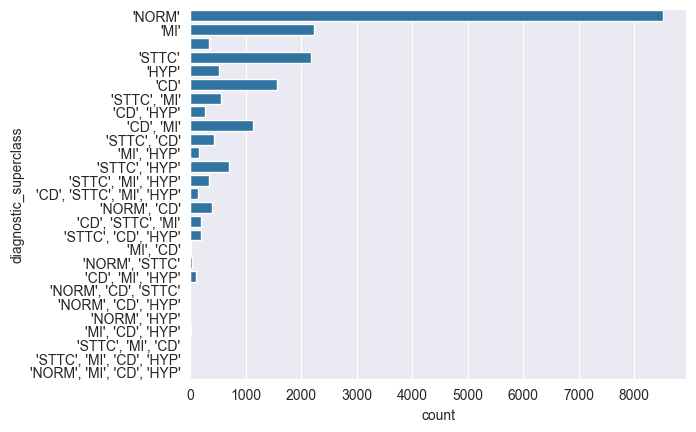

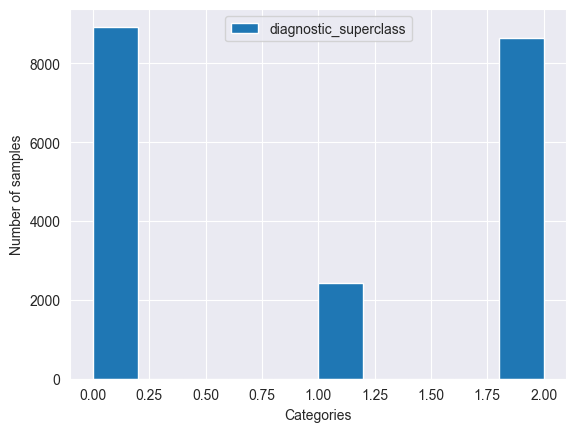

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    2
8    0
9    0
Name: diagnostic_superclass, dtype: int64

In [168]:
import seaborn as sns
sns.countplot(df['diagnostic_superclass'])
plt.show()
df['diagnostic_superclass']=df['diagnostic_superclass'].apply(lambda x: 0 if 'NORM' in x else (1 if 'HYP' in x else 2))

df['diagnostic_superclass'].hist(legend=True)
plt.ylabel('Number of samples')
plt.xlabel('Categories')
plt.show()
df['diagnostic_superclass'].head(10)

In [169]:
df2['diagnostic_superclass'].head(100)

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    0
97    0
98    0
99    0
Name: diagnostic_superclass, Length: 100, dtype: int64

In [170]:
df.to_csv('HYP20_extracted_features.csv', index=False)


In [171]:
df2.to_csv('k20_extracted_features.csv', index=False)
